In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection,metrics
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [18]:
gender= pd.read_csv('gender_submission.csv')
def read_and_concat_dataset(training_path, test_path):
    train = pd.read_csv(training_path)
    train['train'] = 1
    test = pd.read_csv(test_path)
    test['train'] = 0
    data = train.append(test, ignore_index=True)
    return train, test, data
train_df, test_df, combine = read_and_concat_dataset('train.csv', 'test.csv')

In [19]:
print(train_df.columns.values)
print(test_df.columns.values)
print(combine.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked' 'train']
['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked' 'train']
['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked' 'train']


In [20]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [17]:
train_df.info()
print('_'*40)
test_df.info()
print('_'*40)
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train        891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------   

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [9]:
def predict_age(x_train, y_train, x_test):
    param_grid = {
        'learning_rate':[.001, .005, .01, .05, .1],
        'max_depth':[2, 4, 6, 8],
        'n_estimators':[50, 100, 300, 500, 1000],
        'seed':[2018]
    }
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0) 
    tune_model = model_selection.GridSearchCV(XGBRegressor(nthread=-1), param_grid=param_grid, 
                                              scoring = 'neg_mean_squared_error', cv = cv_split)
    tune_model.fit(x_train, y_train)
    print(tune_model.best_params_)
    y_test = tune_model.best_estimator_.predict(x_test)

    return y_test
df_data = pd.concat([train_df, test_df])
data_p = df_data.drop(['Cabin', 'Embarked', 'Name', 'PassengerId', 'Sex', 'Survived', 'Ticket'], 1)
x_train = data_p.loc[~data_p['Age'].isnull(), :].drop('Age', 1)
y_train = data_p.loc[~data_p['Age'].isnull(), :]['Age']
x_test = data_p.loc[data_p['Age'].isnull(), :].drop('Age', 1)
df_data.loc[df_data['Age'].isnull(), 'Age'] = predict_age(x_train, y_train, x_test)

{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 1000, 'seed': 2018}


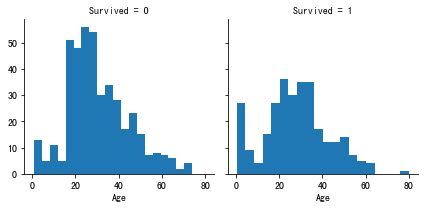

In [14]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

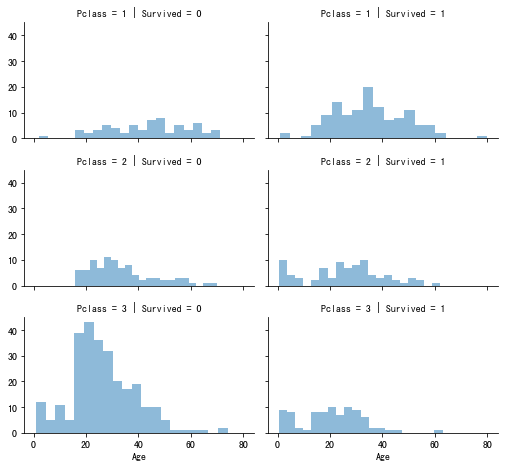

In [15]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

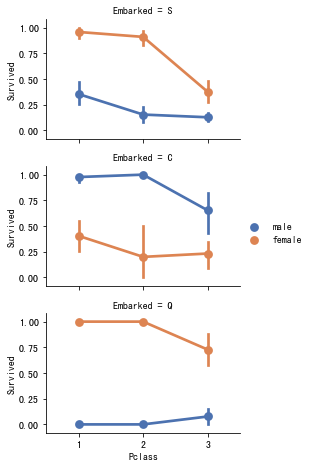

In [16]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

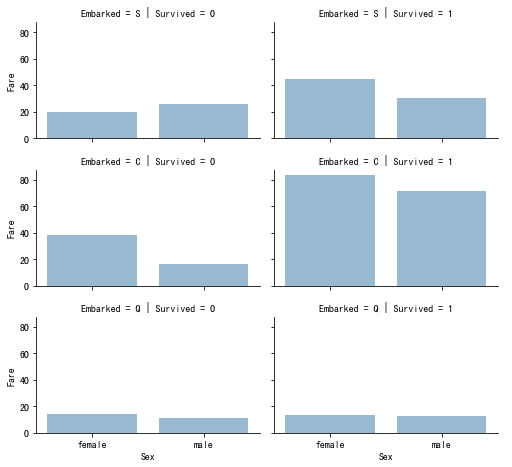

In [16]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()


In [17]:
# for dataset in combine:
#     dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# pd.crosstab(train_df['Title'], train_df['Sex'])

In [15]:
# for dataset in combine:
#     dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
#  	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

#     dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
#     dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
#     dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
# train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [16]:
# title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
# for dataset in combine:
#     dataset['Title'] = dataset['Title'].map(title_mapping)
#     dataset['Title'] = dataset['Title'].fillna(0)

# train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S,1


In [58]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
train_df.shape, test_df.shape

((891, 11), (418, 11))

In [59]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,1,1,1,35.0,1,0,113803,53.1000,C123,S,1
4,0,3,0,35.0,0,0,373450,8.0500,NaN,S,1


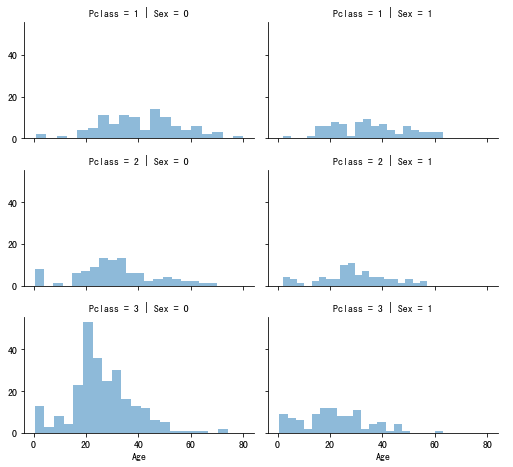

In [60]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

In [61]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [21]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

In [52]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Sex        891 non-null    int64  
 3   Age        891 non-null    float64
 4   Fare       891 non-null    int64  
 5   Embarked   891 non-null    int64  
 6   Title      891 non-null    int64  
 7   IsAlone    891 non-null    int64  
 8   Age*Class  891 non-null    float64
 9   Cabin_A    891 non-null    uint8  
 10  Cabin_B    891 non-null    uint8  
 11  Cabin_C    891 non-null    uint8  
 12  Cabin_D    891 non-null    uint8  
 13  Cabin_E    891 non-null    uint8  
 14  Cabin_F    891 non-null    uint8  
 15  Cabin_G    891 non-null    uint8  
 16  Cabin_T    891 non-null    uint8  
 17  Cabin_X    891 non-null    uint8  
dtypes: float64(2), int64(7), uint8(9)
memory usage: 70.6 KB


In [25]:


def predict_age(x_train, y_train, x_test):
    param_grid = {
        'learning_rate':[.001, .005, .01, .05, .1],
        'max_depth':[2, 4, 6, 8],
        'n_estimators':[50, 100, 300, 500, 1000],
        'seed':[2018]
    }
    cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0) 
    tune_model = model_selection.GridSearchCV(XGBRegressor(nthread=-1), param_grid=param_grid, 
                                              scoring = 'neg_mean_squared_error', cv = cv_split)
    tune_model.fit(x_train, y_train)
    print(tune_model.best_params_)
    y_test = tune_model.best_estimator_.predict(x_test)

    return y_test

data_p = combine.drop(['Cabin', 'Embarked', 'Name', 
                       'Sex', 'Survived', 'Ticket'], 1)
x_train = data_p.loc[~data_p['Age'].isnull(), :].drop('Age', 1)
y_train = data_p.loc[~data_p['Age'].isnull(), :]['Age']
x_test = data_p.loc[data_p['Age'].isnull(), :].drop('Age', 1)
combine.loc[combine['Age'].isnull(), 'Age'] = predict_age(x_train, y_train, x_test)


{'learning_rate': 0.005, 'max_depth': 2, 'n_estimators': 1000, 'seed': 2018}


In [26]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.369942
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [64]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train,AgeBand
0,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,1,"(16.336, 32.252]"
1,1,1,1,2.0,1,0,PC 17599,71.2833,C85,C,1,"(32.252, 48.168]"
2,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,"(16.336, 32.252]"
3,1,1,1,2.0,1,0,113803,53.1000,C123,S,1,"(32.252, 48.168]"
4,0,3,0,2.0,0,0,373450,8.0500,NaN,S,1,"(32.252, 48.168]"


In [65]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,1,1,2.0,1,0,PC 17599,71.2833,C85,C,1
2,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,1,1,1,2.0,1,0,113803,53.1000,C123,S,1
4,0,3,0,2.0,0,0,373450,8.0500,NaN,S,1


In [66]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [67]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [68]:
dataset

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train,FamilySize,IsAlone
0,892,3,0,2.0,0,0,330911,7.8292,NaN,Q,0,1,1
1,893,3,1,2.0,1,0,363272,7.0000,NaN,S,0,2,0
2,894,2,0,3.0,0,0,240276,9.6875,NaN,Q,0,1,1
3,895,3,0,1.0,0,0,315154,8.6625,NaN,S,0,1,1
4,896,3,1,1.0,1,1,3101298,12.2875,NaN,S,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,NaN,0,0,A.5. 3236,8.0500,NaN,S,0,1,1
414,1306,1,1,2.0,0,0,PC 17758,108.9000,C105,C,0,1,1
415,1307,3,0,2.0,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0,1,1
416,1308,3,0,NaN,0,0,359309,8.0500,NaN,S,0,1,1


In [69]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,train,IsAlone
0,0,3,0,1.0,A/5 21171,7.2500,NaN,S,1,0
1,1,1,1,2.0,PC 17599,71.2833,C85,C,1,0
2,1,3,1,1.0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,1,1,1,2.0,113803,53.1000,C123,S,1,0
4,0,3,0,2.0,373450,8.0500,NaN,S,1,1


In [70]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3.0,1.0,3
1,2.0,2.0,1
2,3.0,1.0,3
3,2.0,2.0,1
4,6.0,2.0,3
5,3.0,1.0,3
6,3.0,3.0,1
7,0.0,0.0,3
8,3.0,1.0,3
9,0.0,0.0,2


In [71]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [72]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [73]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,train,IsAlone,Age*Class
0,0,3,0,1.0,A/5 21171,7.2500,NaN,0,1,0,3.0
1,1,1,1,2.0,PC 17599,71.2833,C85,1,1,0,2.0
2,1,3,1,1.0,STON/O2. 3101282,7.9250,NaN,0,1,1,3.0
3,1,1,1,2.0,113803,53.1000,C123,0,1,0,2.0
4,0,3,0,2.0,373450,8.0500,NaN,0,1,1,6.0


In [74]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,train,IsAlone,Age*Class
0,892,3,0,2.0,330911,7.8292,NaN,2,0,1,6.0
1,893,3,1,2.0,363272,7.0000,NaN,0,0,0,6.0
2,894,2,0,3.0,240276,9.6875,NaN,2,0,1,6.0
3,895,3,0,1.0,315154,8.6625,NaN,0,0,1,3.0
4,896,3,1,1.0,3101298,12.2875,NaN,0,0,0,3.0


In [75]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [76]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

AttributeError: 'list' object has no attribute 'info'

In [49]:
X_train = train_df.drop(["Survived","Ticket"], axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop(["PassengerId","Cabin_X"], axis=1).copy()
#X_test["Cabin_T"] = 0 
X_train.shape, Y_train.shape, X_test.shape

((891, 15), (891,), (418, 15))

In [48]:
train_df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train_df['Cabin']])
train_df = pd.get_dummies(train_df)

KeyError: 'Cabin'

In [40]:

test_df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test_df['Cabin']])
test_df = pd.get_dummies(test_df)
combine = [train_df, test_df]

In [45]:

X_test["Cabin_T"] = 0 
X_test = X_test

In [46]:
X_test.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,3,0,2.0,0,2,1,1,6.0,0,0,0,0,0,0,0,0
1,3,1,2.0,0,0,3,0,6.0,0,0,0,0,0,0,0,0
2,2,0,3.0,1,2,1,1,6.0,0,0,0,0,0,0,0,0
3,3,0,1.0,1,0,1,1,3.0,0,0,0,0,0,0,0,0
4,3,1,1.0,1,0,3,0,3.0,0,0,0,0,0,0,0,0


In [47]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,3,0,1.0,0,0,1,0,3.0,0,0,0,0,0,0,0
1,1,1,2.0,3,1,3,0,2.0,0,0,1,0,0,0,0
2,3,1,1.0,1,0,2,1,3.0,0,0,0,0,0,0,0
3,1,1,2.0,3,0,3,0,2.0,0,0,1,0,0,0,0
4,3,0,2.0,1,0,1,1,6.0,0,0,0,0,0,0,0


In [51]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

/Users/wujim/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [144]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.203164
12,Cabin_E,1.064102
11,Cabin_D,0.823960
13,Cabin_F,0.823479
9,Cabin_B,0.456895
5,Title,0.413116
2,Age,0.272099
4,Embarked,0.265479
8,Cabin_A,0.188606
6,IsAlone,0.149776


In [145]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

78.23

In [146]:
#KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

86.08

In [147]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

74.19

In [148]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

59.26

In [149]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/Users/wujim/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


79.57

In [150]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

76.32

In [151]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

89.34

In [177]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

89.34

In [167]:

train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_train, Y_train,
                                                                    test_size=0.25,stratify=Y_train,random_state=0)
eval_set = [(train_x,train_y),(valid_x,valid_y)]

In [175]:

xgbc = XGBClassifier(objective='binary:logistic', learning_rate=1)
xgbc.fit(X_train, Y_train,eval_metric=['auc'],eval_set=eval_set,verbose=True)
Y_pred = xgbc.predict(X_test)
xgbc.score(X_train, Y_train)
acc_xgb = round(xgbc.score(X_train, Y_train) * 100, 2)
acc_xgb

[99]	validation_0-auc:0.95367	validation_1-auc:0.93473


88.66

In [155]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'XGBoost'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_xgb]})
models.sort_values(by='Score', ascending=False)


,Model,Score
3,Random Forest,89.34
8,Decision Tree,89.34
9,XGBoost,88.66
1,KNN,86.08
2,Logistic Regression,80.81
7,Linear SVC,79.57
0,Support Vector Machines,78.23
6,Stochastic Gradient Decent,76.32
4,Naive Bayes,74.19
5,Perceptron,59.26


In [159]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index=False)